# Generative Model

This notebook deals with finding a good generative model.

# TODO: VAE, Diffusion Model & (Sharpening U-Net GAN)

In [15]:
# Imports
import import_ipynb

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR, ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchsummary import summary
from utils import DEVICE, classes, train_data, test_data, BaseModule, train_transforms, QuickDrawDataset # type: ignore
import os
import polars as pl
import matplotlib.pyplot as plt
import umap.umap_ as umap
import warnings

In [55]:
# Global variables

# Hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
PATIENCE = 100
ALPHA = 0.1

# Data loaders
TRAIN_LOADER = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=6)
TEST_LOADER = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=6)

# LR scheduler lambda function
def lr_lambda(epoch):
    return 0.95 ** (epoch - 1)

## Conditional Variatonal Autoencoder

First of all I want to start with a CNN-based variatonal Autoencoder. This way I can apply the knowledge that I gained while building the Classifier Model earlier.

In [3]:
# VAE loss function - combines reconstruction loss and KL divergence
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    BCE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE, KLD, (BCE + beta * KLD)

In [54]:
# Define the Conditional Variational Autoencoder (CVAE) model
class CVAE(nn.Module):
    def __init__(self, latent_dim=30, num_classes=len(classes)):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # label embedding to inject the information into the encoder
        self.label_embed_conv = nn.Linear(num_classes, 28 * 28)

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=3, padding=1),  # 1 channel image + 1 channel label map
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.3),
        )

        # Latent mappings
        self.fc_input_dim = 64 * 7 * 7
        self.fc_mu = nn.Linear(self.fc_input_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.fc_input_dim, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim + num_classes, 64 * 7 * 7)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.3),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.3),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    # Reparameterization trick to sample from the latent space
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        batch_size = x.size(0)

        # One-hot label to image-size label map
        y_onehot = F.one_hot(y, self.num_classes).float().to(x.device)
        y_map = self.label_embed_conv(y_onehot).view(batch_size, 1, 28, 28)

        # Concatenate image and label map
        x_cat = torch.cat([x, y_map], dim=1)

        x_encoded = self.encoder(x_cat)
        x_flat = x_encoded.view(batch_size, -1)

        mu = self.fc_mu(x_flat)
        logvar = self.fc_logvar(x_flat)
        z = self.reparameterize(mu, logvar)

        # Decode
        z_cat = torch.cat([z, y_onehot], dim=1)
        x_decoded = self.fc_decode(z_cat)
        x_decoded = x_decoded.view(batch_size, 64, 7, 7)
        recon_x = self.decoder(x_decoded)

        return recon_x, mu, logvar, z

    def sample(self, z, y):
        y_onehot = F.one_hot(y, self.num_classes).float().to(z.device)
        z_cat = torch.cat([z, y_onehot], dim=1)
        x_decoded = self.fc_decode(z_cat)
        x_decoded = x_decoded.view(z.size(0), 64, 7, 7)
        samples = self.decoder(x_decoded)
        return samples

In [34]:
def kl_anneal(epoch, total_epochs, max_beta=1.0):
    """Linear annealing from 0 to max_beta"""
    return min(max_beta, max_beta * epoch / total_epochs)


In [5]:
def sample_conditional_images(model, epoch, num_classes=5, latent_dim=50, device=DEVICE):
    with torch.no_grad():
        z = torch.randn(num_classes, latent_dim).to(device)
        y = torch.arange(num_classes).to(device)
        samples = model.sample(z, y).cpu()

        _, axes = plt.subplots(1, num_classes, figsize=(num_classes*2, 2))
        for i in range(num_classes):
            ax = axes[i]
            ax.imshow(samples[i].squeeze(), cmap='gray')
            ax.axis('off')
            ax.set_title(classes[i])

        plt.suptitle(f'Sampled Images at Epoch {epoch}', y=1.05)
        plt.subplots_adjust(top=0.8)
        plt.show()

In [6]:
# Plots a UMAP projection to visualize the latent space of the model
def plot_umap(z_all, y_all, epoch, class_names):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        reducer = umap.UMAP(n_components=2, random_state=None)
    z_2d = reducer.fit_transform(z_all)

    # Get unique classes sorted to align with colorbar ticks
    unique_classes = sorted(set(y_all))

    # Create a dict mapping class index to name
    class_labels = [class_names[c] for c in unique_classes]

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_all, cmap='tab10', alpha=0.6)

    # Setup colorbar with ticks and labels
    cbar = plt.colorbar(scatter, ticks=unique_classes)
    cbar.ax.set_yticklabels(class_labels)

    plt.title(f't-SNE Projection of Latent Space at Epoch {epoch}')
    plt.xlabel("t-SNE dim 1")
    plt.ylabel("t-SNE dim 2")
    plt.show()


Epoch 1 | Learning Rate 0.0010
Loss: 494.6105 | Reconstruction Loss: 494.6105 | KL Divergence: 1404.4871
Epoch 2 | Learning Rate 0.0010
Loss: 489.6196 | Reconstruction Loss: 486.6942 | KL Divergence: 390.0529
Epoch 3 | Learning Rate 0.0010
Loss: 473.7422 | Reconstruction Loss: 470.9821 | KL Divergence: 184.0110
Epoch 4 | Learning Rate 0.0010
Loss: 468.7465 | Reconstruction Loss: 465.7930 | KL Divergence: 131.2632
Epoch 5 | Learning Rate 0.0010
Loss: 460.9281 | Reconstruction Loss: 457.5090 | KL Divergence: 113.9701
Epoch 6 | Learning Rate 0.0010
Loss: 464.4125 | Reconstruction Loss: 460.4221 | KL Divergence: 106.4115
Epoch 7 | Learning Rate 0.0010
Loss: 467.5361 | Reconstruction Loss: 462.7633 | KL Divergence: 106.0622
Epoch 8 | Learning Rate 0.0010
Loss: 451.6958 | Reconstruction Loss: 446.3664 | KL Divergence: 101.5134
Epoch 9 | Learning Rate 0.0010
Loss: 466.2854 | Reconstruction Loss: 460.2732 | KL Divergence: 100.2029
Epoch 10 | Learning Rate 0.0010
Loss: 466.5759 | Reconstruction

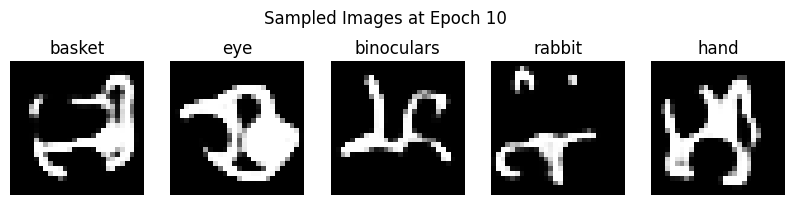

Epoch 11 | Learning Rate 0.0010
Loss: 475.8627 | Reconstruction Loss: 468.4706 | KL Divergence: 98.5613
Epoch 12 | Learning Rate 0.0010
Loss: 452.3862 | Reconstruction Loss: 444.7722 | KL Divergence: 92.2904
Epoch 13 | Learning Rate 0.0010
Loss: 454.4754 | Reconstruction Loss: 445.9196 | KL Divergence: 95.0645
Epoch 14 | Learning Rate 0.0010
Loss: 464.6582 | Reconstruction Loss: 455.7041 | KL Divergence: 91.8371
Epoch 15 | Learning Rate 0.0010
Loss: 471.5575 | Reconstruction Loss: 461.7168 | KL Divergence: 93.7211
Epoch 16 | Learning Rate 0.0010
Loss: 453.1899 | Reconstruction Loss: 443.0174 | KL Divergence: 90.4221


KeyboardInterrupt: 

In [56]:
# Training and evaluation loop for the CVAE model

kl = []
recon = []
loss = []

# Beta parameter for KL divergence weighting
"""
beta = 5 caused KL Divergence to collapse
beta = 2 training plateaued after 10 epochs
"""
beta = 0.75

model = CVAE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.9)
# Params for early stopping
best_loss = float('inf')
epochs_no_improve = 0

# Create directories for saving weights if they don't exist
os.makedirs(os.path.dirname(f'../weights/generative/cvae.pt'), exist_ok=True)

model.train()
for epoch in range(NUM_EPOCHS):

    z_all = []
    y_all = []

    for i, (x, labels) in enumerate(TRAIN_LOADER):
        x = x.to(DEVICE)
        labels = labels.to(DEVICE)

        x_reconst, mu, log_var, z = model(x,labels)
        current_beta = kl_anneal(epoch, NUM_EPOCHS, beta)
        reconst_loss, kl_div, train_loss = vae_loss(x_reconst, x, mu, log_var, current_beta)

        recon.append(reconst_loss.item()/len(x))
        kl.append(kl_div.item()/len(x))
        loss.append(train_loss.item()/len(x))

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        z_all.append(z.detach().cpu())
        y_all.append(labels.detach().cpu())

    #scheduler.step(train_loss)

    # Early stopping logic
    if train_loss < best_loss:
        best_loss = train_loss
        epochs_no_improve = 0
        torch.save(model, f'../weights/generative/cvae.pt')
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping at epoch {epoch+1}")
        break

    print(f"Epoch {epoch+1} | Learning Rate {optimizer.param_groups[0]['lr']:.4f}\n"
        f"Loss: {train_loss.item()/len(x):.4f} | "
        f"Reconstruction Loss: {reconst_loss.item()/len(x):.4f} | "
        f"KL Divergence: {kl_div.item()/len(x):.4f}")


    if (epoch + 1) % 10 == 0:
        model.eval()
        if (epoch + 1) % 50 == 0:
            # Visualize the latent space using UMAP
            z_all = torch.cat(z_all)
            y_all = torch.cat(y_all)
            plot_umap(z_all.numpy(), y_all.numpy(), epoch + 1, classes)
        sample_conditional_images(model, epoch + 1, model.num_classes, model.latent_dim, DEVICE)
        model.train()

## Conditional GAN

## Conditional Diffusion Model